### Instalando bibliotecas necessárias

In [ ]:
%pip3 install -r requests.txt

### Importando bibliotecas

In [41]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import requests
import ipywidgets as widgets
from IPython.display import display
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from datetime import date

### Carregando dados de ações em um dataframe

In [4]:
html = requests.get("https://investnews.com.br/financas/veja-a-lista-completa-dos-bdrs-disponiveis-para-pessoas-fisicas-na-b3/")
df_acoes = pd.read_html(html.text, header=0)[0]
linha_inicial = pd.DataFrame({'EMPRESA': ['Escolha'], 'CÓDIGO': ['Escolha'], 'SETOR': ['Escolha'], 'PAÍS DE ORIGEM': ['Escolha']})
df_acoes = pd.concat([linha_inicial, df_acoes]).reset_index(drop=True)

### Criando um menu de escolha de ações

In [5]:
acoes_selecionadas =[]

# Cria o menu dropdown de Setores
col1_dropdown = widgets.Dropdown(options=list(df_acoes['SETOR'].unique()), description='Setor:')

# Define a função que será chamada quando o usuário selecionar um valor no menu dropdown de Setores
def update_col2_options(*args):
    col1_value = col1_dropdown.value
    col2_dropdown.options = list(df_acoes[df_acoes['SETOR'] == col1_value]['CÓDIGO'].unique())

# Cria o menu dropdown de ações
col2_dropdown = widgets.Dropdown(description='Ação:')

# Observa o menu dropdown de Setores para atualizar o menu dropdown de ações quando um setor for selecionado
col1_dropdown.observe(update_col2_options, 'value')

# Cria um botão
botao = widgets.Button(description='Adicionar à lista')

# criando o objeto Text com o valor inicial da lista
texto = widgets.Text(value=str(acoes_selecionadas), description='Seleção:')
texto.layout.width = '800px'

#col2_dropdown.observe(on_dropdown_acoes_change, names='value')
def valor_selecionado(b):
    acoes_selecionadas.append(col2_dropdown.value)
    texto.value = str(acoes_selecionadas)

# Adiciona o valor do menu dropdown de ações à lista, ao pressionar o botão
botao.on_click(valor_selecionado)

# Cria um objeto VBox para exibir os menus dropdown na vertical
widgets.VBox([col1_dropdown, col2_dropdown, botao, texto])

### Adicionando '.SA' às ações escolhidas

In [6]:
for i in range(len(acoes_selecionadas)):
    acoes_selecionadas[i] = acoes_selecionadas[i] + '.SA'

In [ ]:
print(date)

### Função para criar um modelo preditivo Tensorflow de uma determinada ação (no período entre 01/01/2021 e 01/03/2023) e calcular o valor futuro, no dia 30/06/2023

In [39]:
def geraModeloTF(acao):
    # Download dos dados históricos da ação
    historico = yf.download(acao, start="2021-01-01", end="2023-03-01", progress=False)

    # Selecionando apenas a coluna de data e preço de fechamento da ação
    historico.drop(['Open','High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)
    historico.index.names = ['Data']
    historico.rename(columns={'Close': 'Preco'}, inplace=True)

    # Criando lista com os valores de fechamento da ação
    y=[]
    for a in historico['Preco']:
        y.append(a)

    # Criando lista com a contagem de dias contidos no período selecionado
    x = np.arange(1, len(y) + 1, 1)

    # Padronizando os valores da lista de preços da ação (preparação para o aprendizado de máquina)
    y = (y - np.min(y)) / (np.max(y) - np.min(y))
    
    # Separando os dados em conjuntos distintos para treino e teste
    percent_treino = 0.8
    qtd_treino = int(percent_treino * (len(x)))
    x_treino = x[0:qtd_treino] 
    x_teste = x[qtd_treino:]

    y_treino = y[0:qtd_treino]
    y_teste = y[qtd_treino:]

    treino = np.array(list(zip(x_treino, y_treino)))
    teste = np.array(list(zip(x_teste, y_teste)))

    # Estruturação dos dados
    def preparar_dados(dados_serie, look_back):
        X, y =[],[]
        n = len(dados_serie)
        for i in range(n - look_back):
            posicao_fim = i + look_back
            if posicao_fim <= n:
                seq_x = dados_serie[i:posicao_fim,1]
                seq_y = dados_serie[posicao_fim,1]
                X.append(seq_x)
                y.append(seq_y)
        return np.array(X), np.array(y)
    
    look_back = 2
    x_treino, y_treino = preparar_dados(treino, look_back)
    x_teste, y_teste = preparar_dados(teste, look_back)

    num_caracteristicas = 1
    x_treino = x_treino.reshape((x_treino.shape[0], 
                             x_treino.shape[1], 
                             num_caracteristicas))
    x_teste = x_teste.reshape((x_teste.shape[0], 
                       x_teste.shape[1], 
                       num_caracteristicas))
    
    # Criação do modelo de redes neurais
    num_etapas = x_treino.shape[1]
    num_caracteristicas = x_treino.shape[2]
    epocas = 20
    num_unidades = 100
    tf.random.set_seed(7777)
    modelo = Sequential()
    camada_de_entrada=(num_etapas, num_caracteristicas)
    modelo.add(LSTM(num_unidades, return_sequences = True, input_shape = camada_de_entrada))
    modelo.add(Dropout(0.2))
    modelo.add(LSTM(128, input_shape = camada_de_entrada))
    modelo.add(Dense(1))

    # Configurando algorítimos de cálculo de precisão do modelo e otimizador
    modelo.compile(loss='mean_squared_error', optimizer='adam')

    # Treinando o modelo
    modelo_treinado = modelo.fit(x_treino, y_treino, epochs = epocas, verbose = 0, batch_size = 70, shuffle = False, validation_split = 0.3)

    # Exibindo informações do modelo treinado
    print('=================================== {} ==================================='.format(acao))
    print("Precisão: {}".format(str(modelo.evaluate(x_teste, y_teste, batch_size=64, verbose=0))))
    print('=================================================================================')
    plt.title(acao + ': Cálculo do Erro ao longo do treinamento')
    plt.ylabel('Erro')
    plt.xlabel('Época')
    plt.plot(modelo_treinado.history['loss'])
    plt.plot(modelo_treinado.history['val_loss'])
    plt.legend(['loss (treinamento)', 'val_loss (validação)'], loc='upper right')
    plt.show()

    predicao = modelo.predict(x_teste, verbose=0)
    look_back = 1
    valores_reais_y = y_teste
    plt.plot(list(range(len(valores_reais_y))), valores_reais_y, marker='.', label="Real")
    lst_dados_predicao=[w[0] for w in predicao]
    plt.plot(list(np.arange(len(predicao))-look_back), lst_dados_predicao, 'r',label="Estimação do Modelo")
    plt.title(acao + ': Visualizando a assertividade do modelo treinado')
    plt.ylabel('Valores', size=10)
    plt.xlabel('Período', size=10)
    plt.legend(fontsize=10)
    plt.show()
    print(x_teste)
    return modelo

=================================== W1YC34.SA ===================================
Precisão: 0.01989656873047352


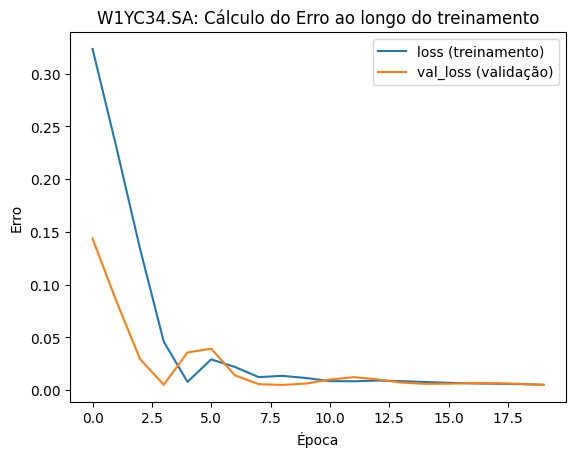

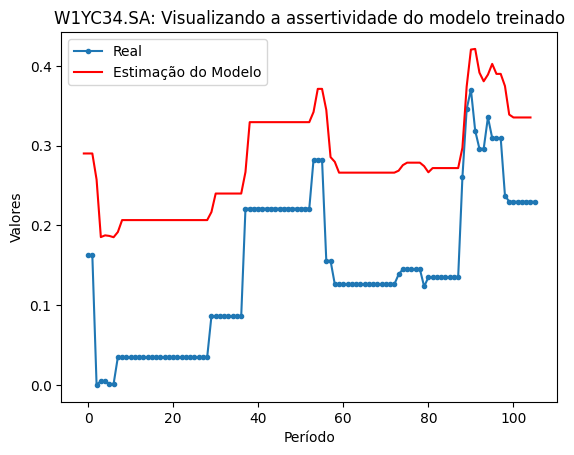

[[[0.16259172]
  [0.16259172]]

 [[0.16259172]
  [0.16259172]]

 [[0.16259172]
  [0.16259172]]

 [[0.16259172]
  [0.        ]]

 [[0.        ]
  [0.00489009]]

 [[0.00489009]
  [0.00489009]]

 [[0.00489009]
  [0.00122257]]

 [[0.00122257]
  [0.00122257]]

 [[0.00122257]
  [0.03484115]]

 [[0.03484115]
  [0.03484115]]

 [[0.03484115]
  [0.03484115]]

 [[0.03484115]
  [0.03484115]]

 [[0.03484115]
  [0.03484115]]

 [[0.03484115]
  [0.03484115]]

 [[0.03484115]
  [0.03484115]]

 [[0.03484115]
  [0.03484115]]

 [[0.03484115]
  [0.03484115]]

 [[0.03484115]
  [0.03484115]]

 [[0.03484115]
  [0.03484115]]

 [[0.03484115]
  [0.03484115]]

 [[0.03484115]
  [0.03484115]]

 [[0.03484115]
  [0.03484115]]

 [[0.03484115]
  [0.03484115]]

 [[0.03484115]
  [0.03484115]]

 [[0.03484115]
  [0.03484115]]

 [[0.03484115]
  [0.03484115]]

 [[0.03484115]
  [0.03484115]]

 [[0.03484115]
  [0.03484115]]

 [[0.03484115]
  [0.03484115]]

 [[0.03484115]
  [0.03484115]]

 [[0.03484115]
  [0.08630804]]

 [[0.086

In [40]:
modelo = geraModeloTF("W1YC34.SA")